### notebook purpose

- evaluate results for many initializations

In [1]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics_imgs, plot_row_qdess, scale_0_1
from utils.data_io import get_mtr_ids_and, load_imgs, load_qdess

### diff in metrics b/w two paths

In [10]:
def get_mu_diff(path_bl, path_new, inits_bl=None, inits_new=None):
    ''' get diff in metrics between two paths '''
    
    mtr_id_list = get_mtr_ids_and(path_bl, path_new)

    imgs_gt = load_imgs(mtr_id_list, path=path_gt)
    
    if 'many_inits' in path_bl:
        imgs_bl = load_imgs_many_inits(mtr_id_list, path_bl, 
                                        num_inits=inits_bl,
                                        avg_inits=True)
    else:
        imgs_bl = load_imgs(mtr_id_list, path=path_bl)
    
    if 'many_inits' in path_new:
        imgs_new = load_imgs_many_inits(mtr_id_list, path_new, 
                                        num_inits=inits_new,
                                        avg_inits=True)
    else:
        imgs_new = load_imgs(mtr_id_list, path=path_new)

    metrics_bl = calc_metrics_imgs(imgs_gt, imgs_bl)
    metrics_new = calc_metrics_imgs(imgs_gt, imgs_new)
    
    mu_bl = np.around(np.mean(metrics_bl, 0), 4)
    mu_new = np.around(np.mean(metrics_new, 0), 4)
    
    # perc improvement for each metrics, avg across echos
    mu_perc = mu_new / mu_bl
    mu_perc = np.mean(mu_perc, axis=0)
    
    return mu_perc, metrics_bl, metrics_new

### img loader specific to `many_inits/` expmt

In [33]:
def load_imgs_many_inits(mtr_id_list, path, num_inits=None, avg_inits=True):
    ''' load images where each sample was reconed multiple times 
        num_inits to control how many restarts are loaded '''

    # indicator string if loading gt
    gt_str = '_gt' if '/gt/' in path else ''

    num_samps = len(mtr_id_list)
    if num_inits == None:
        num_inits = 4
    num_echos, num_y, num_z = 2, 512, 160
    arr = np.empty((num_samps, num_inits, num_echos, num_y, num_z))

    for idx_s, mtr_id in enumerate(mtr_id_list):
        
        for idx_i in np.arange(num_inits):

            arr[idx_s, idx_i, 0] = np.load('{}MTR_{}_e1{}_init{}.npy'.format(path, mtr_id, gt_str, idx_i))
            arr[idx_s, idx_i, 1] = np.load('{}MTR_{}_e2{}_init{}.npy'.format(path, mtr_id, gt_str, idx_i))

    if avg_inits:    
        arr = np.mean(arr, axis=1) #avg across inits
        
    return arr

In [58]:
accel = 4
path_base = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

path_gt = path_base + 'gt/'
path_bl = path_base + 'many_inits/iter_10k/'
path_new = path_base + 'many_inits/iter_10k/'

inits_bl = 1
inits_new = 4

### load imgs, calc metrics

In [59]:
mtr_id_list = get_mtr_ids_and(path_bl, path_new)

imgs_gt = load_imgs(mtr_id_list, path=path_gt)
imgs_bl = load_imgs_many_inits(mtr_id_list, path=path_bl, 
                               num_inits=inits_bl, avg_inits=True)
imgs_new = load_imgs_many_inits(mtr_id_list, path=path_new, 
                                num_inits=inits_new, avg_inits=True)
    
metrics_bl = calc_metrics_imgs(imgs_gt, imgs_bl)
metrics_new = calc_metrics_imgs(imgs_gt, imgs_new)

### avg metrics across all samples

In [60]:
print(mtr_id_list)

mu_bl = np.around(np.mean(metrics_bl, 0), 4)
mu_new = np.around(np.mean(metrics_new, 0), 4)
mu_diff = mu_new - mu_bl
print('\n', mu_bl, '\n', mu_new, '\n\n', mu_diff, '\n', mu_new/mu_bl-1)

['005', '006', '030', '065', '066', '080']

 [[ 0.8984  0.9713  0.8677 33.4693]
 [ 0.7625  0.9466  0.8066 33.4744]] 
 [[ 0.907   0.9805  0.9041 35.1418]
 [ 0.7864  0.9604  0.8478 34.7602]] 

 [[0.0086 0.0092 0.0364 1.6725]
 [0.0239 0.0138 0.0412 1.2858]] 
 [[0.00957257 0.00947184 0.04194998 0.04997117]
 [0.03134426 0.01457849 0.0510786  0.03841144]]


### indiv sample metrics

In [73]:
for idx_s, mtr_id in enumerate(mtr_id_list):
    
#     if mtr_id != '005':
#         continue
    
    print(mtr_id)
#     print(metrics_bl[idx_s])
#     print(metrics_new[idx_s])
    print(np.around(metrics_new[idx_s] / metrics_bl[idx_s] - 1, 4))
    sys.exit()

005
[[0.0127 0.008  0.0306 0.044 ]
 [0.07   0.0202 0.0607 0.0364]]


SystemExit: 

### plot

0.6990759336978292
1.0978413773224758


SystemExit: 

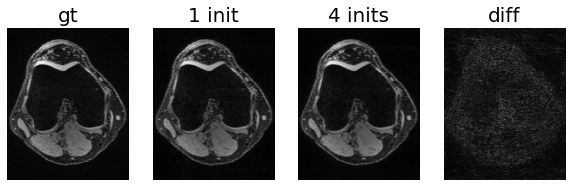

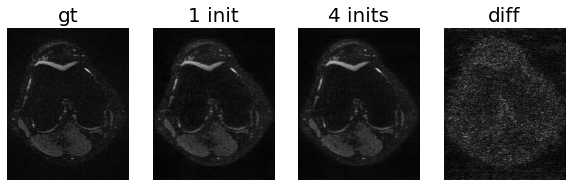

In [74]:
title_list = ['gt', '1 init', '4 inits']
clim_list = [None] * len(title_list)
DIFF_MAP = True

for idx_s in np.arange(imgs_gt.shape[0]):
    for idx_e in np.arange(imgs_gt.shape[1]):
        
        im_gt, im1, im2 = imgs_gt[idx_s, idx_e], \
                          imgs_bl[idx_s, idx_e], \
                          imgs_new[idx_s, idx_e]
#         im_gt, im1, im2 = scale_0_1(im_gt), scale_0_1(im1), scale_0_1(im2)
        arr_list = [im_gt, im1, im2]
        
        if DIFF_MAP:
            C = 10 # constant for plotting on clim=(0,1)
            im_diff = C * np.abs(scale_0_1(im1) - scale_0_1(im2))
            print(im_diff.max())
            arr_list.append(im_diff)
            title_list.append('diff')
            clim_list.append((0,1))
                
        plot_row_qdess(arr_list, title_list, clim_list)
        
    sys.exit()

# OLD

### compare across num_inits x num_iter

In [2]:
mu_inits = np.empty((4,4))

for ii, inits in enumerate([1,2,3,4]):
    
    mu_perc, m_bl, m_new = get_mu_diff(path_bl, path_new,
                                       inits_bl=1,
                                       inits_new=inits)
        
    mu_inits[ii] = mu_perc
    
mu_inits = mu_inits.transpose() - 1

In [ ]:
metrics_list = ['vif', 'msssim', 'ssim', 'psnr']

for mm, mu in enumerate(mu_inits):
    
    plt.plot(mu, label=metrics_list[mm])
    
plt.title('Improvement obtained via re-inits, 5k iter, 8x')
plt.ylabel('percent improvement')
plt.xlabel('re-inits')
plt.xticks([0,1,2,3])
plt.legend()
plt.show()